Multiple Myeloma data challenge
============================
Technical test for Data Scientist (DS) position in the Computational Biology team

Katarzyna Wreczycka 20.10.2022




Clinical context
-------------------
Multiple Myeloma (MM) is a type of bone marrow cancer. Treatment for MM involves
combinations of drugs over multiple cycles. There is huge heterogeneity in treatment
response with some individuals being non-responders and some patients remaining well for
some time before a relapse. A better characterization of patients who relapse early can
influence the treatment options and combinations.

In this test, we propose to develop a model for predicting the risk of dying or relapsing of
newly diagnosed multiple myeloma patients from baseline clinical and expression data.


Data
--------------------------
The data for this test are extracted from an old Synapse Dream Challenge
(https://www.synapse.org/#!Synapse:syn6187098/wiki/401884) .
It consists of clinical data, gene expression data and follow-up for newly diagnosed Multiple
Myeloma patients extracted from the MMRF CoMMpass IA9 study. In the data, newly
diagnosed MM patients are classified as High Risk (HR) when they relapse or die before 18
months.
To access the data, you first need to create an account and download the following files:
- Expression data:
MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv
(https://www.synapse.org/#!Synapse:syn10573789)
[notice that the first column gives Entrez IDs for genes]
- Clinical data and labels:
sc3_Training_ClinAnnotations.csv
(https://www.synapse.org/#!Synapse:syn9926878)
- Explanation of the clinical and label annotations:
Harmonized_Clinical_Dictionary
(https://www.synapse.org/#!Synapse:syn9744732)



Goal
--------------------------------------
The purpose of this technical test is to develop a model for predicting the risk of fast dying or
relapsing of newly diagnosed multiple myeloma patients (using the High Risk label
HR_FLAG).The evaluation will mostly rely on the way you approach the problem: pre-analysis,
preprocessing strategy, choice of modelization and coding skills.
The code should be developed so that the model can be applied to an external validation
dataset. You will send your code (Notebook or script) along with a small report to interpret
the model and put it in MM context (the use of the literature is clearly welcome).
Your model can be developed in Python or R with a small README to explain how to apply
it to external data.

You can use external knowledge/data to develop the model. Please add all the requirements
for libraries that should be installed to make it run.

If not used to survival analysis, the candidate can consider a simplified version in which it
can assumed that no censored patients will be present in the external validation dataset.

(Obvious) suggestion: OS and PFS related variables are also labels and not features:
HR_FLAG is defined as OS or PFS < 18 months (taking into account censoring).

Results
-----------------------


In [1]:
# Load libraries
suppressPackageStartupMessages(library(tidyverse));
suppressPackageStartupMessages(library(data.table));
suppressPackageStartupMessages(library(org.Hs.eg.db));
suppressPackageStartupMessages(library(stats));

suppressPackageStartupMessages(library(ggfortify)); 
suppressPackageStartupMessages(library(ggplot2));

suppressPackageStartupMessages(library(glmnet));
suppressPackageStartupMessages(library(survival));
suppressPackageStartupMessages(library(maxstat))

suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(dichromat))

library(SurvMetrics)
library(caret)
library(randomForestSRC)
library(survival)  
library(pec)
library(ggplot2)


Attaching package: ‘SurvMetrics’


The following object is masked from ‘package:glmnet’:

    Cindex


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:SurvMetrics’:

    MAE


The following object is masked from ‘package:survival’:

    cluster


The following object is masked from ‘package:purrr’:

    lift



 randomForestSRC 3.1.1 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 



Attaching package: ‘randomForestSRC’


The following object is masked from ‘package:purrr’:

    partial


Loading required package: prodlim


Attaching package: ‘pec’


The following object is masked from ‘package:caret’:

    R2




Gene expression data pre-processing
---------------------

In [2]:
# Load the input data
clinical_data = read.csv("./Harmonized_Clinical_Dictionary.csv", sep=",", header=TRUE,fill = TRUE, stringsAsFactors = FALSE)
edata = read.csv("./MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv", sep=",", header=TRUE,stringsAsFactors = FALSE,row.names=1)
annot_data = read.csv("./sc3_Training_ClinAnnotations.csv", sep=",", header=TRUE, stringsAsFactors = FALSE)

# Convert ISS stages into a factor vector
annot_data$D_ISS = as.factor(as.character(annot_data$D_ISS))
levels(annot_data$D_ISS) <- list("I"="1","II"="2","III"="3")

# Filter the input datasets for the patients with their annotation data
colnames(edata) = gsub("_1_BM","",colnames(edata))
intersect_labels = intersect(colnames(edata),annot_data$Patient)
edata = edata[, match(intersect_labels, colnames(edata), nomatch = 0)]
annot_data = annot_data[match(intersect_labels, annot_data$Patient, nomatch = 0), ]

# add prefix "gene" to entrez ids of genes
rownames(edata) = paste0("gene",rownames(edata))

# name rows of annotation table by patient ids
rownames(annot_data) = annot_data$Patient

# Overview of the variables
print(clinical_data[which(clinical_data$names=="Study"),]$description)
table(annot_data$Study)

print("PatientType")
table(annot_data$PatientType)

print(clinical_data[which(clinical_data$names=="D_Gender"),]$description)
table(annot_data$D_Gender)

print(clinical_data[which(clinical_data$names=="D_Age"),]$description)
summary(annot_data$D_Age)

print("HR_FLAG")
table(annot_data$HR_FLAG)

print(clinical_data[which(clinical_data$names=="D_ISS"),]$description)
table(annot_data$D_ISS)

print(clinical_data[which(clinical_data$names=="D_OS_FLAG"),]$description)
table(annot_data$D_OS_FLAG)

print(clinical_data[which(clinical_data$names=="D_OS"),]$description)
summary(annot_data$D_OS)

print(clinical_data[which(clinical_data$names=="D_OS_FLAG"),]$description)
table(annot_data$D_OS_FLAG)

print(clinical_data[which(clinical_data$names=="D_PFS"),]$description)
summary(annot_data$D_PFS)

[1] "Study cohort this patient belongs to"



MMRF 
 582 

[1] "PatientType"



NewlyDiagnosed 
           582 

[1] "Gender string"



Female   Male 
   235    347 

[1] "Age at diagnosis (years)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  27.00   57.00   65.00   64.15   71.00   93.00 

[1] "HR_FLAG"



CENSORED    FALSE     TRUE 
     191      261      130 

[1] "ISS Disease Stage"



  I  II III 
189 209 164 

[1] "Is the patient deceased?"



  0   1 
486  96 

[1] "Overall Survival time: number of days from (trial randomization or diagnosis) to (death or last assessment)."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   354.5   617.0   624.3   814.0  1581.0 

[1] "Is the patient deceased?"



  0   1 
486  96 

[1] "Progression-free survival: number of days from (trial randomization or diagnosis) to (disease progression, death, or last assessment)."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   280.2   510.0   536.7   722.8  1572.0 

1. Filtering data and scaling.

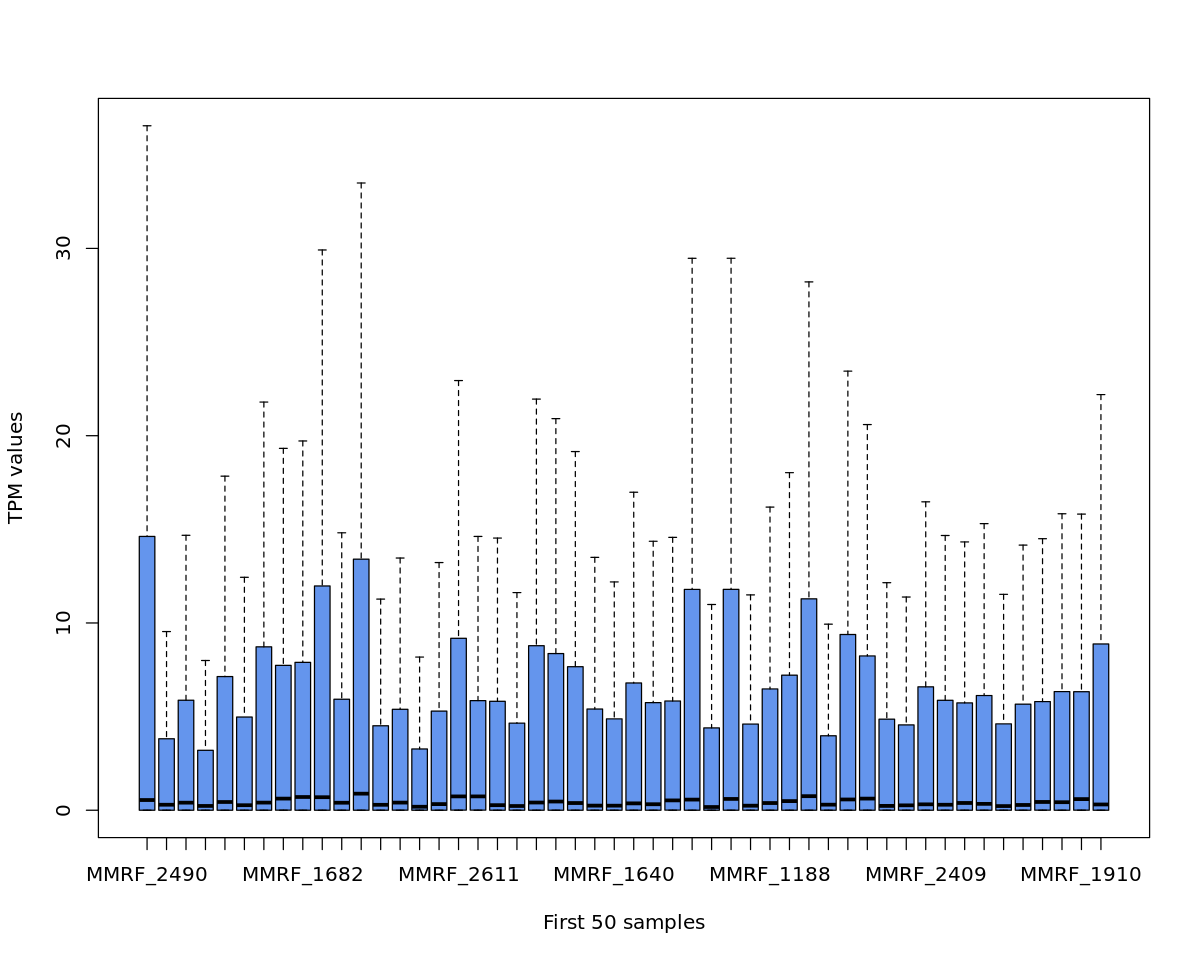

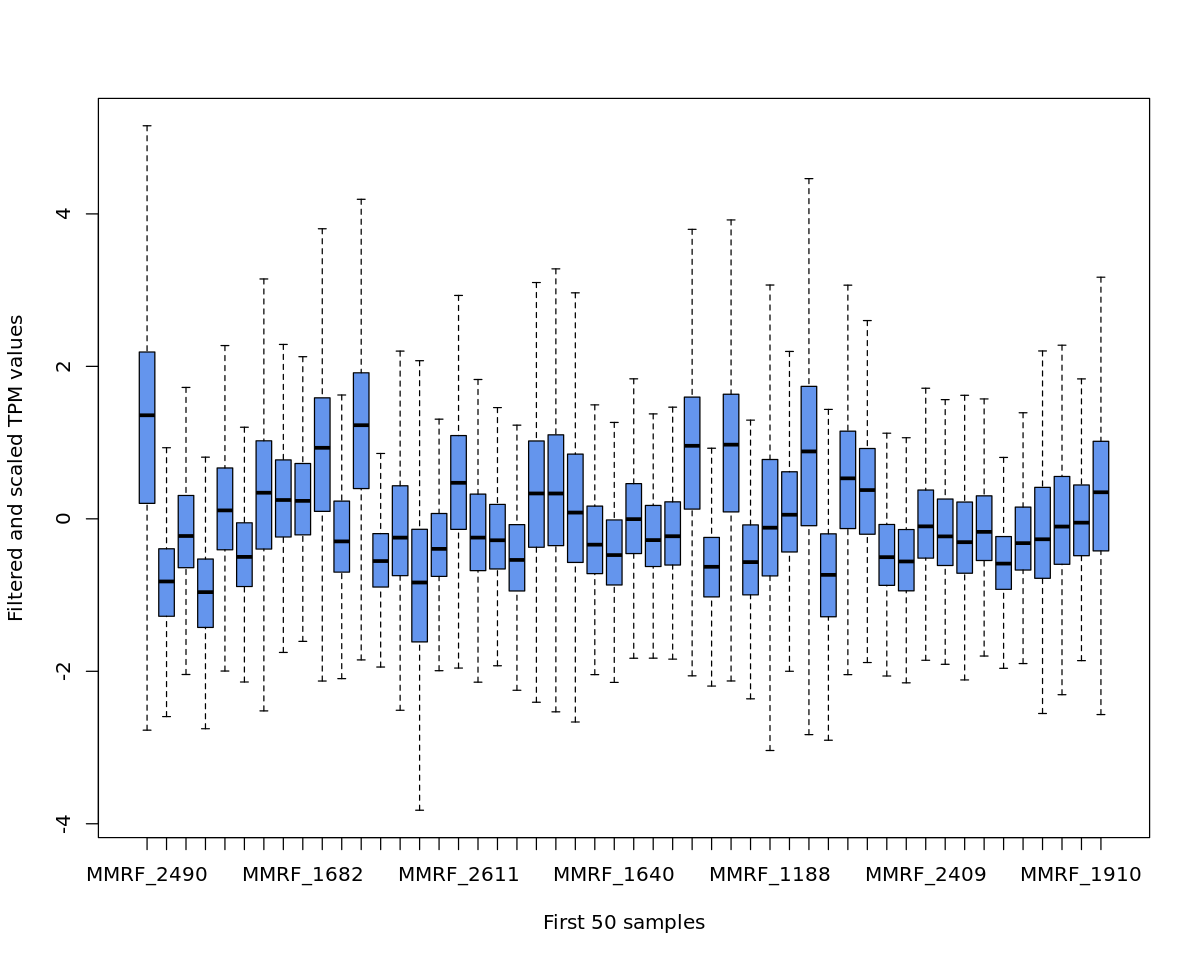

In [3]:
options(repr.plot.width=10, repr.plot.height=8)

# check if there are NA values in the expression matrix
if(anyNA(edata)) print("There are NAs in the expression matrix.")

# plot input TPM values to check if the expression data needs filtering and scaling 
# for simplicity plot just first 50 samples
boxplot(edata[,1:50],outline=FALSE,col="cornflowerblue",
        #main="Car Milage Data",
        xlab="First 50 samples", ylab="TPM values")

# remove genes with no expression in more 50% of samples
fif <- dim(edata)[2]/2
no.exp.count <- apply(edata, 1, function(x) sum(which(x == 0)))
edataf = edata[-no.exp.count,]  
                      
# remove genes with variance equal to 0
#edataf = edataf[, which(apply(edataf, 2, var) != 0)]
# filter genes based on variance between samples
gene.iqr <- apply(edataf, 1, IQR)                   
#plot(density(gene.iqr)) 
edataf = edataf[which(gene.iqr > 0.1),] # it removes half of the genes
                                            
# log transform the expression data to Z scores
gexp=log2(edataf+1)

# transform the expression data to Z scores
gexpn <- t(scale(t(gexp)))

# Plot input TPM values after filtering and scaling 
# for simplicity plot just first 50 samples
boxplot(gexpn[,1:50],outline=FALSE,col="cornflowerblue",
        xlab="First 50 samples", ylab="Filtered and scaled TPM values")
                       

Unsupervised expolaratory analysis - clustering and PCA
---------------------

Based on the hierarchical clustering of gene expression I can see that I filtered out genes that group in clusters based on their expression. PCA analysis shows that there should be no bigger issues with batch effects, that could be further removed by using for example the Combat algorithm to find out latent factors.




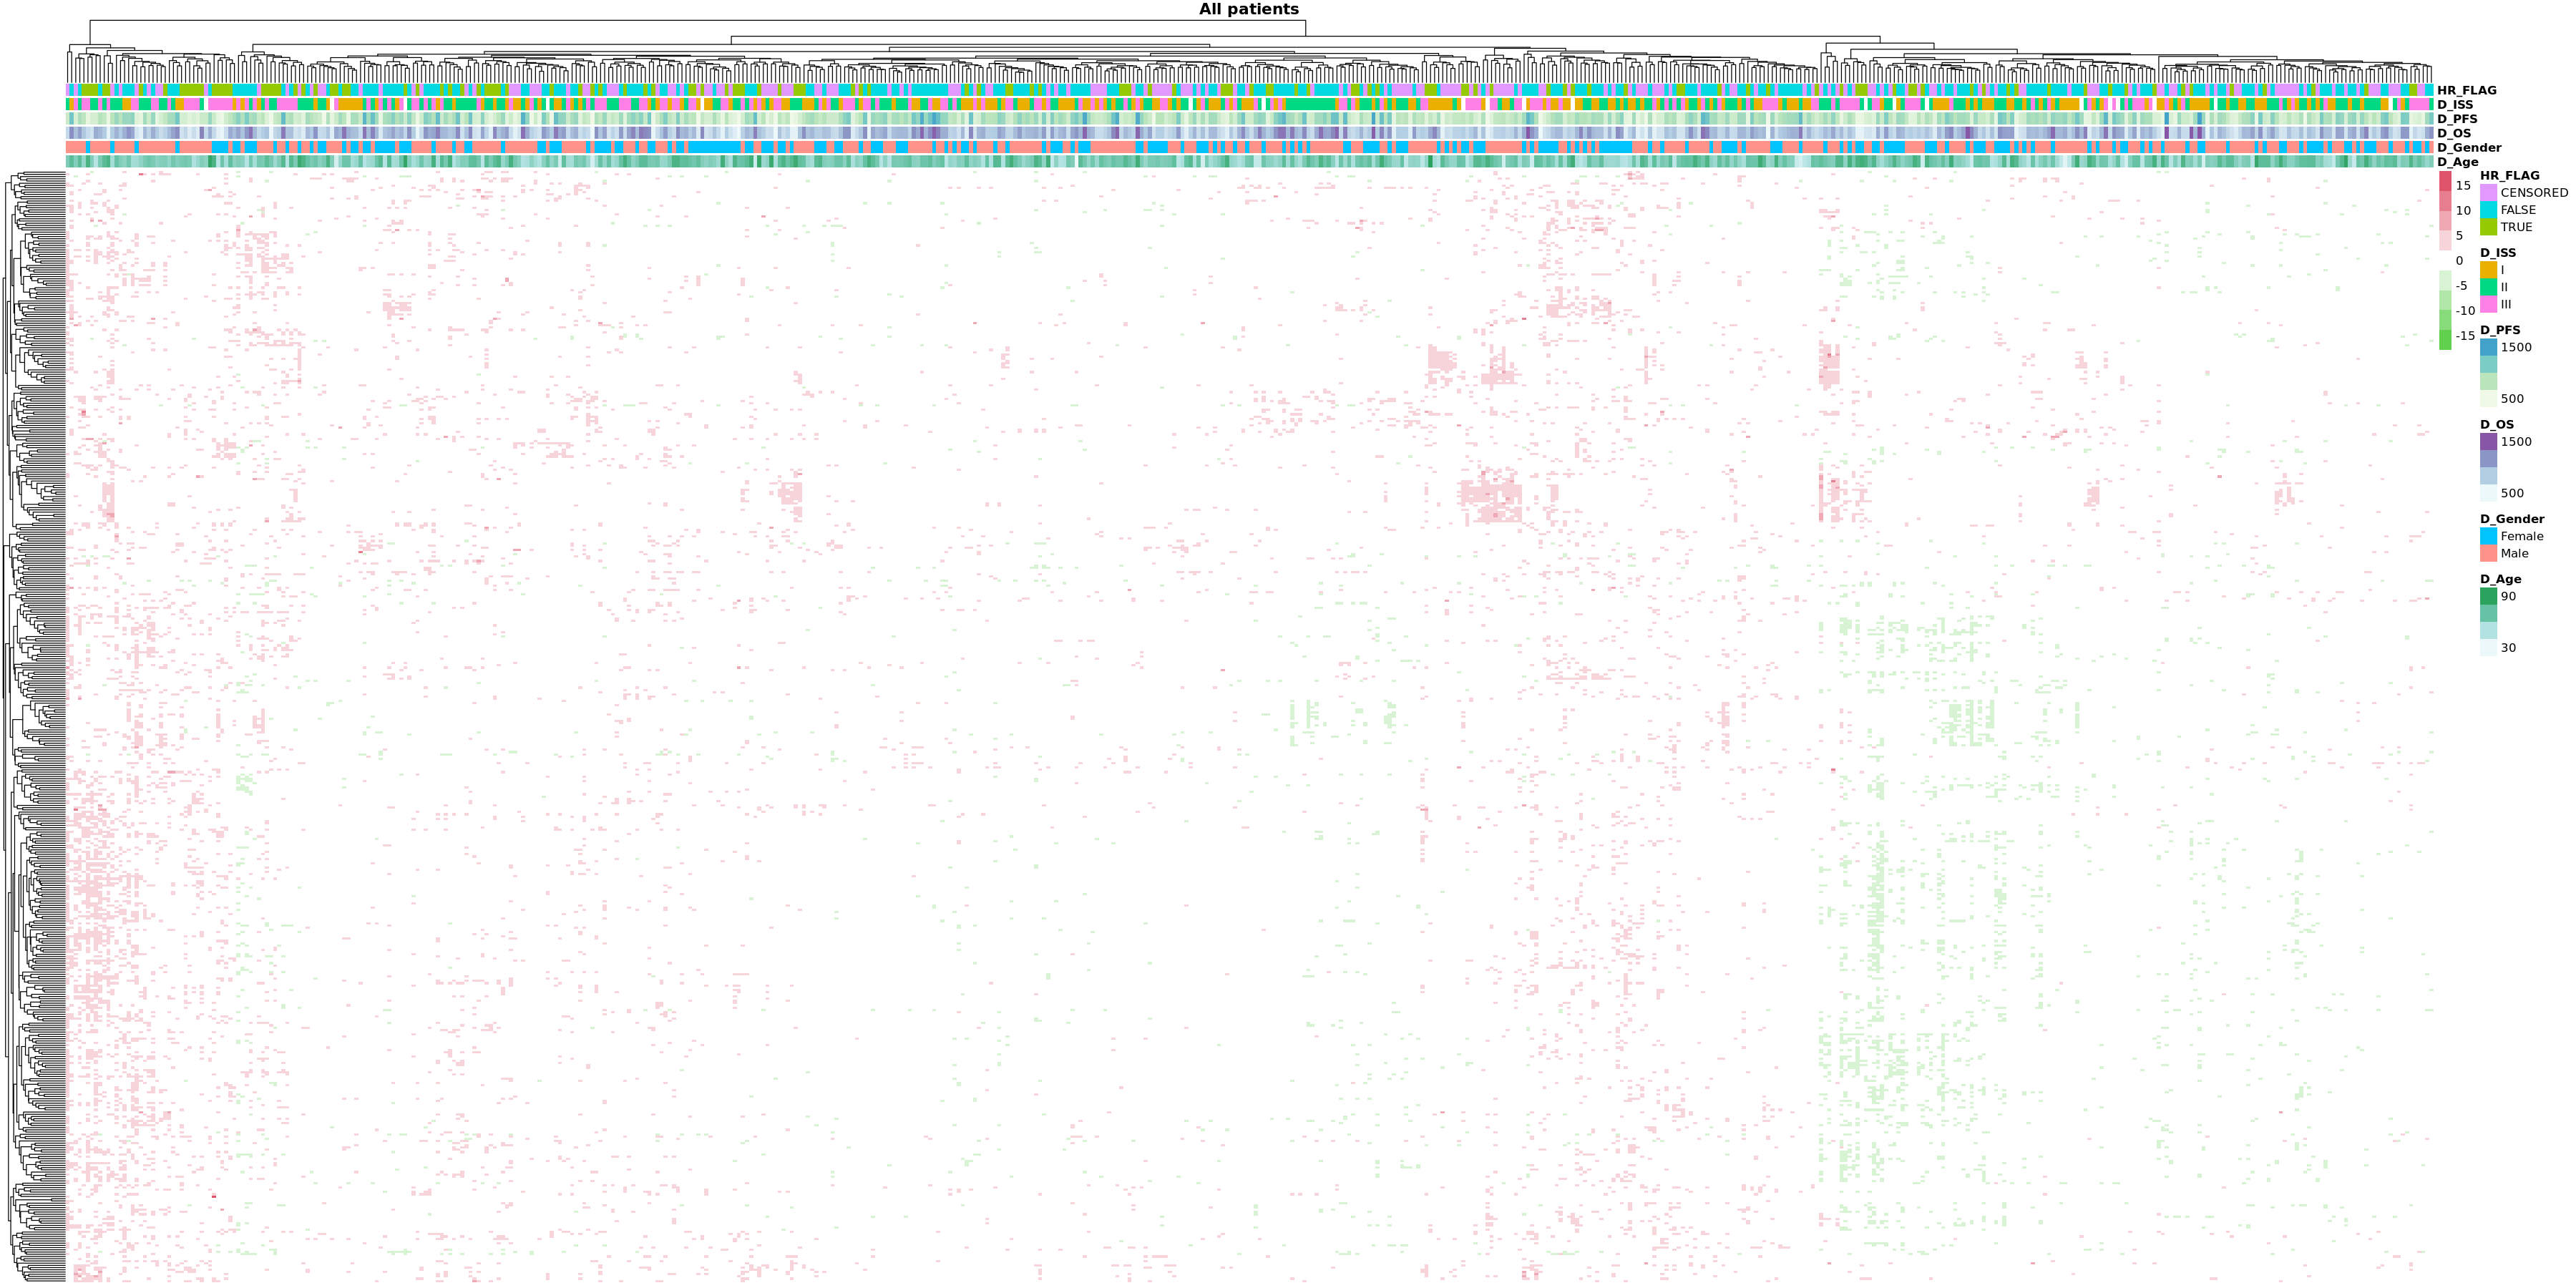

In [4]:
#compute the variance of each gene across samples
V <- apply(gexpn, 1, var)

#sort the results by variance in decreasing order and select the top 100 genes 
selectedGenes <- names(V[order(V, decreasing = T)][1:500])

annot_sel_col <- c("D_Age", 
                   "D_Gender", 
                   "D_OS",
                   "D_PFS", 
                   "D_ISS", 
                   "HR_FLAG"
                  )
colData <- annot_data[which(colnames(annot_data) %in% annot_sel_col)]
rownames(colData) = annot_data$Patient

options(repr.plot.width=30, repr.plot.height=15)
colramp = colorRampPalette(c(3,"white",2))(9)
pheatmap(gexpn[selectedGenes,], 
         scale = 'row', 
         show_rownames = FALSE, 
         show_colnames = FALSE, 
         annotation_col = colData,
         col=colramp,
         main="All patients")

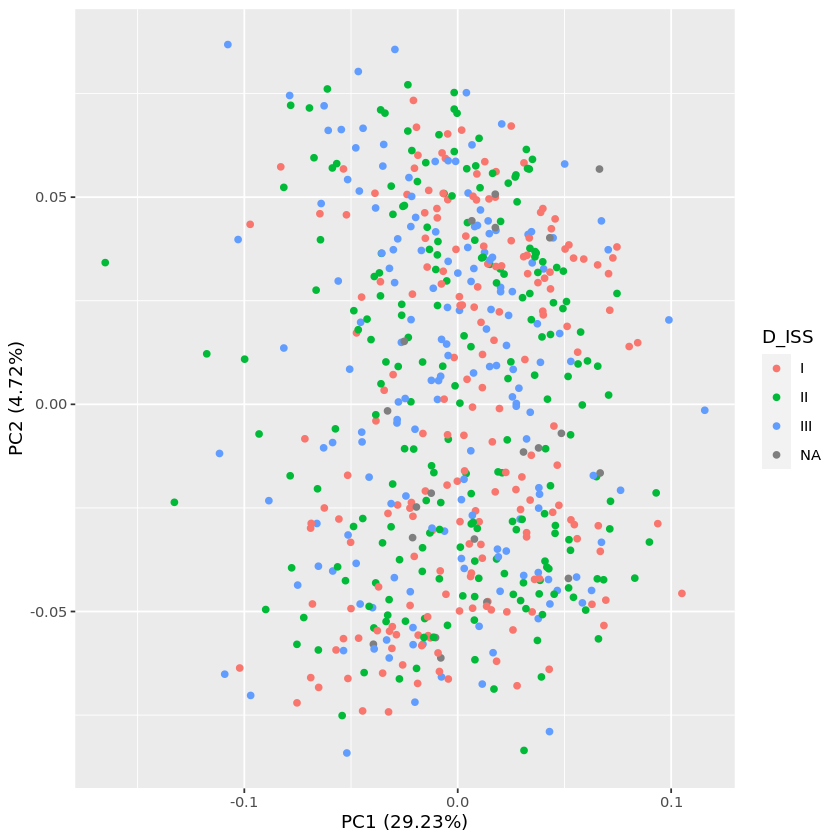

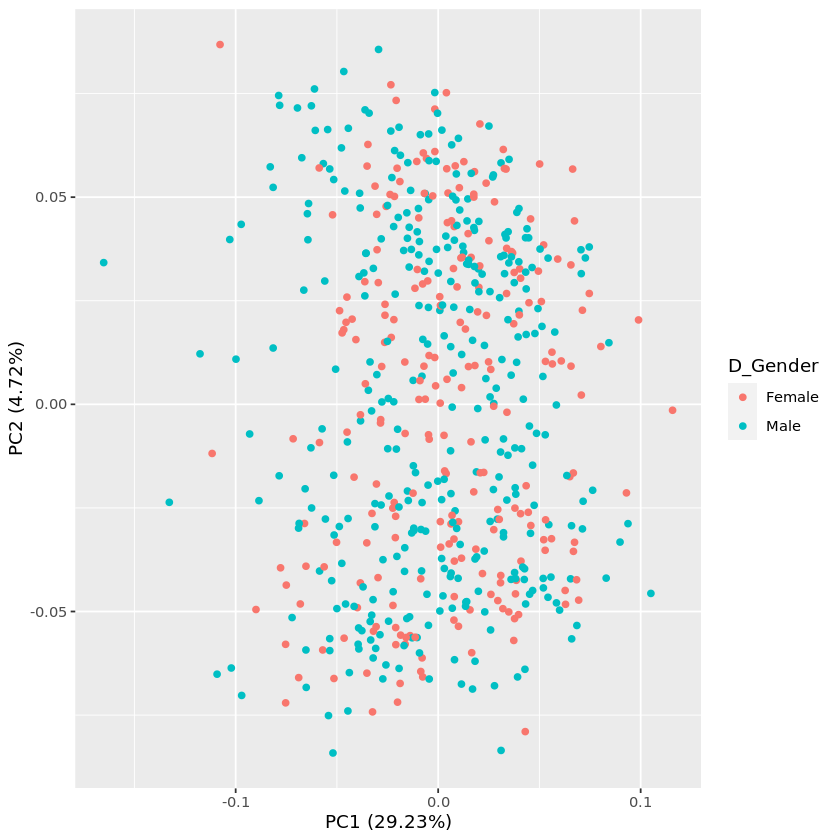

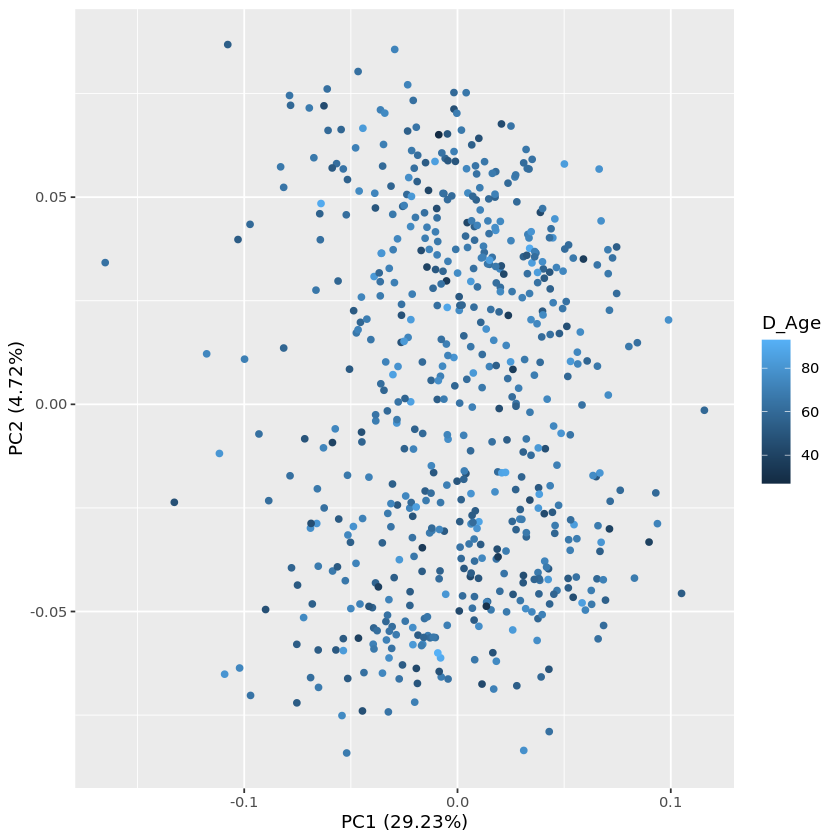

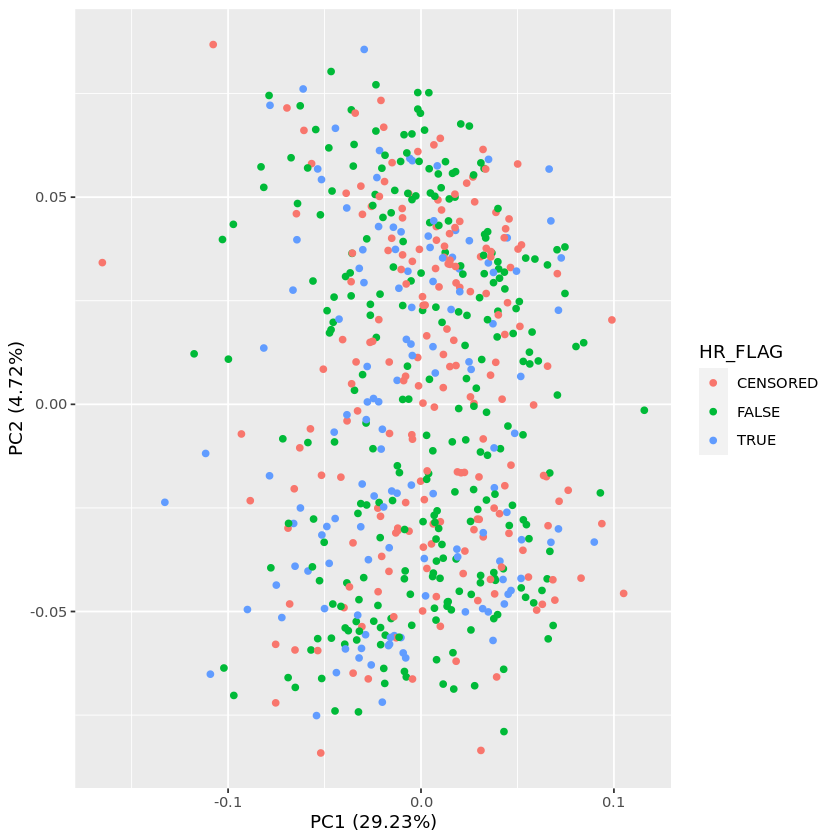

In [5]:
options(repr.plot.width=7, repr.plot.height=7)

# compute PCA 
pcaResults <- prcomp(t(gexpn), center = FALSE)
 
# plot PCA
autoplot(pcaResults, data = annot_data, colour = 'D_ISS')
autoplot(pcaResults, data = annot_data, colour = 'D_Gender')
autoplot(pcaResults, data = annot_data, colour = 'D_Age')
autoplot(pcaResults, data = annot_data, colour = 'HR_FLAG')

Modeling
---------------------------------------------------------
1. baseline cox model age + ISS
2. regularized cox model with age + ISS gene expression
3. gene-by-gene cox model age + ISS + gene
4. logistic regression 
5. regularized random forest
6. asses performance of all models and pick the best one



The larger the C index, the better the model prediction. It can be seen that the performance of Cox is better than RSF.

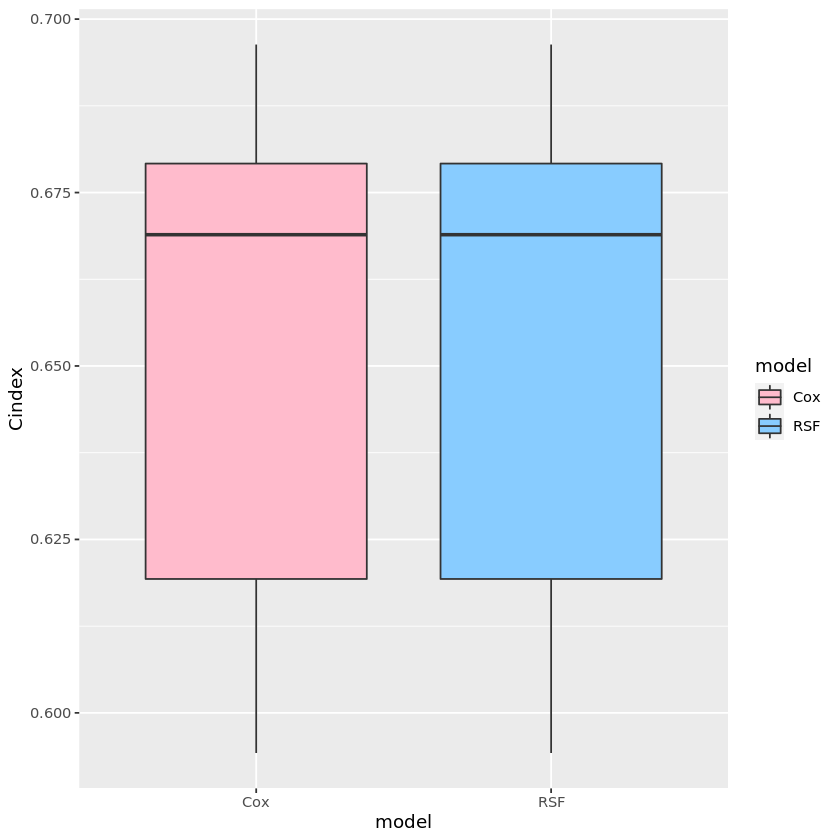

In [6]:
set.seed(123)

#Initialization
metrics_cox = 0
metrics_rsf = 0
for (i in 1:5) {
    
  y = annot_data
  # remove NA from data
  y = y[-which(is.na(annot_data$D_ISS)),] 
    
  y$time = y$D_PFS
  y$status = y$D_PFS_FLAG                       

  index <- createDataPartition(y$status, p = 0.7, list = F)
  train_data <- y[index, ] # 70%
  test_data <- y[-index, ] # 30%     
  
  #fit the models
  fitrsf = rfsrc(Surv(time, status) ~ D_ISS + D_Age, data = train_data, 
                 nsplit = 3, ntree = 500)
  mat_rsf = predict(fitrsf, test_data)$survival
  
  dis_time = fitrsf$time.interest
  #print(dis_time)
  fitcox = coxph(Surv(time, status) ~ D_ISS + D_Age, data = train_data, x = TRUE)
  # extract survival probability predictions
  mat_cox = predictSurvProb(fitcox, test_data, dis_time)
  
  #calculate the C index
  med_index = median(1:length(dis_time))
  surv_obj = Surv(test_data$time, test_data$status)
  
  #C index for Cox
  metrics_cox[i] = Cindex(surv_obj, predicted = mat_cox[, med_index])
  #C index for RSF
  metrics_rsf[i] = Cindex(surv_obj, predicted = mat_rsf[, med_index])
  
}

data_CI = data.frame('Cindex' = c(metrics_cox, metrics_rsf),
                     'model' = c(rep('Cox', 20), rep('RSF', 20)))

ggplot(data_CI, aes(x = model, y = Cindex, fill = model)) +
  geom_boxplot() +
  scale_fill_manual(values = c("#FFBBCC", "#88CCFF"))



In [49]:
library(cvTools)

y_annot = annot_data[-which(is.na(annot_data$D_ISS)),]
y_annot = y_annot[,c("D_PFS","D_PFS_FLAG","D_Age","D_ISS")]
colnames(y_annot) = c("time", "status", "age", "ISS")
y_train.iss <- model.matrix( ~ .-1, y_annot)

x_expr = t(gexpn)[-which(is.na(annot_data$D_ISS)),]


x_geneexp = cbind(y_train.iss[,c("age",
                                "ISSI","ISSII","ISSIII"
                               )], x_expr) # "D_ISS"
y_train = y_train.iss[,c("time", "status")]

# Remove NA from the data
#x_geneexpr.age.iss.nona = x_geneexpr.age.iss[-which(is.na(x_geneexpr.age.iss$D_ISS)),]
#y_annot.nona = y_annot[-which(is.na(x_geneexpr.age.iss$D_ISS)),]

#x_geneexpr.age.iss.nona$D_ISS = as.character(x_geneexpr.age.iss.nona$D_ISS)


#head(x_geneexpr.age.iss.nona)
#exit()

# Search for the best alpha for the elastic net
# it takes too long on my computer, and due to lack
# of enough RAM my R crashes
#alpha <- seq(0.01, 0.99, 0.1)
#best <- list(a=NULL, mse=NULL)
#for (i in 1:length(alpha)){
#    print(alpha[i])
#    model <- cv.glmnet(x=as.matrix(x_geneexpr.age.iss), 
#                       y=as.matrix(y_annot),
#                       family = 'cox')   
#    best$a <- c(best$a, alpha[i])
#    best$mse <- c(best$mse, model$cvm[model$lambda == model$lambda.1se])
#}
#index <- which(best$mse==min(best$mse))
#best_alpha <- best$a[index]
#best_mse <- best$mse[index]
#best_alpha


# https://stat.ethz.ch/pipermail/r-help/2013-September/360821.html

metrics_lasso = 0
for (i in 1:5) {
    
  y = annot_data
  # remove NA from data
  y = y[-which(is.na(annot_data$D_ISS)),] 
    
  y$time = y$D_PFS
  y$status = y$D_PFS_FLAG                       

  index <- createDataPartition(y$status, p = 0.7, list = F)
  train_data <- y[index, ] # 70%
  test_data <- y[-index, ] # 30% 
    
  model <- cv.glmnet(x=as.matrix(x_geneexp)[train_data,], 
                     y=as.matrix(y_train)[train_data,],
                     family = 'cox',
                     nfolds = 3,
                     alpha=1) # LASSO
    
 pred = predict(glmnet.cox.meaningful,reformat_testSet)
 cIndexCoxglmnet = 1-rcorr.cens(pred,
                                Surv(reformat_testSet$time,reformat_testSet$status))
 metrics_lasso = c(metrics_lasso, pred)   
    
}



# Function to minimize to identify the best-fit alpha value
model <- cv.glmnet(x=as.matrix(x_geneexp), 
                   y=as.matrix(y_train),
                   family = 'cox',
                   nfolds = 3,
                   alpha=1) # LASSO#

#head(model)

#for (i in 1:length(alpha)) 
#{
#   cvg <- cv.glmnet(x, y, family = "gaussian", alpha = alpha[i])
#   best$a <- c(best$a, alpha[i])
#   best$mse <- c(best$mse, min(cvg$cvm))
#}
 

#1-rcorr.cens(predict(glmnet.cox.meaningful,reformat_testSet),
 #            Surv(reformat_testSet$time,reformat_testSet$status))

#fit.elasticnet.noclinvar <- glmnet(as.matrix(x_geneexpr), as.matrix(y_annot), family = "cox", alpha=0.5) #TODO:alpha=1 by default


$lambda
  [1] 0.152726250 0.145784607 0.139158471 0.132833504 0.126796016 0.121032942
  [7] 0.115531808 0.110280709 0.105268280 0.100483674 0.095916536 0.091556982
 [13] 0.087395576 0.083423312 0.079631594 0.076012215 0.072557342 0.069259499
 [19] 0.066111548 0.063106676 0.060238380 0.057500453 0.054886969 0.052392271
 [25] 0.050010962 0.047737886 0.045568126 0.043496984 0.041519979 0.039632832
 [31] 0.037831458 0.036111960 0.034470616 0.032903873 0.031408341 0.029980784
 [37] 0.028618111 0.027317374 0.026075757 0.024890573 0.023759258 0.022679363
 [43] 0.021648551 0.020664591 0.019725354 0.018828806 0.017973008 0.017156107
 [49] 0.016376335 0.015632006 0.014921507 0.014243301 0.013595921 0.012977966
 [55] 0.012388097 0.011825039 0.011287573 0.010774535 0.010284816 0.009817355
 [61] 0.009371141 0.008945208 0.008538635 0.008150541 0.007780086 0.007426469
 [67] 0.007088925 0.006766722 0.006459164 0.006165585 0.005885350 0.005617852
 [73] 0.005362511 0.005118777 0.004886121 0.004664039 0.004452051 0.004249699
 [79] 0.004056543 0.003872167 0.003696171 0.003528174 0.003367814 0.003214741
 [85] 0.003068626 0.002929152 0.002796018 0.002668935 0.002547627 0.002431834
 [91] 0.002321303 0.002215796 0.002115085 0.002018951 0.001927187 0.001839593
 [97] 0.001755981 0.001676169 0.001599984 0.001527263

$cvm
  [1]  12.41578  12.40674  12.39594  12.38296  12.36744  12.34946  12.33030
  [8]  12.31188  12.29534  12.28175  12.27007  12.25982  12.25187  12.24413
 [15]  12.23772  12.23578  12.23819  12.24122  12.24209  12.24545  12.25691
 [22]  12.27063  12.28473  12.30794  12.33662  12.37725  12.41850  12.46640
 [29]  12.54201  12.64211  12.75719  12.86648  12.96806  13.09376  13.28605
 [36]  13.52891  13.80308  14.11770  14.47348  14.86652  15.31242  15.81991
 [43]  16.44957  17.24325  18.14983  19.14081  20.19686  21.34983  22.67863
 [50]  24.31019  26.23219  28.22645  30.31348  32.41127  34.39545  36.28422
 [57]  38.10213  39.90538  41.68569  43.50216  45.33801  47.20636  49.08884
 [64]  50.99284  52.92834  54.91657  56.98072  59.08703  61.15347  63.20645
 [71]  65.28129  67.44738  69.85916  72.50062  75.24873  78.04261  80.82984
 [78]  83.66758  86.62213  89.71794  92.95577  96.44167 100.08662 103.79372
 [85] 107.54554 111.37055 115.28456 119.28410 123.31501 127.37818 131.46515
 [92] 135.68203 139.96326 144.35292 148.82534 153.38247 157.54567 160.68114
 [99] 163.30117 164.61939

$cvsd
  [1] 3.172127e-02 2.665864e-02 2.252581e-02 2.043169e-02 2.269411e-02
  [6] 2.827552e-02 3.293684e-02 3.561346e-02 3.553008e-02 3.293568e-02
 [11] 2.910711e-02 2.506269e-02 1.993679e-02 1.612252e-02 1.264649e-02
 [16] 8.975474e-03 4.640755e-03 9.653225e-04 1.869883e-03 4.460204e-03
 [21] 1.313925e-02 1.987645e-02 1.915654e-02 2.127576e-02 2.783723e-02
 [26] 4.276818e-02 5.716316e-02 6.720351e-02 8.895440e-02 1.217696e-01
 [31] 1.560295e-01 1.749908e-01 1.817606e-01 1.951945e-01 2.404612e-01
 [36] 3.148102e-01 3.985678e-01 4.965539e-01 6.025615e-01 7.046743e-01
 [41] 8.058055e-01 9.207297e-01 1.089192e+00 1.318455e+00 1.569403e+00
 [46] 1.843045e+00 2.153573e+00 2.473069e+00 2.815389e+00 3.226038e+00
 [51] 3.748120e+00 4.310519e+00 4.934367e+00 5.554236e+00 6.086864e+00
 [56] 6.525555e+00 6.887379e+00 7.207109e+00 7.455963e+00 7.670931e+00
 [61] 7.853813e+00 8.024220e+00 8.189849e+00 8.335703e+00 8.474615e+00
 [66] 8.610117e+00 8.730083e+00 8.819720e+00 8.930457e+00 9.113314e+00
 [71] 9.294363e+00 9.478161e+00 9.797850e+00 1.021187e+01 1.062752e+01
 [76] 1.100545e+01 1.120921e+01 1.130199e+01 1.135040e+01 1.142804e+01
 [81] 1.150089e+01 1.163557e+01 1.187067e+01 1.212730e+01 1.251285e+01
 [86] 1.300114e+01 1.352137e+01 1.409549e+01 1.473382e+01 1.540862e+01
 [91] 1.612200e+01 1.687753e+01 1.773464e+01 1.862342e+01 1.946688e+01
 [96] 2.023795e+01 2.115426e+01 2.237908e+01 2.296299e+01 2.216142e+01

$cvup
  [1]  12.44750  12.43340  12.41846  12.40339  12.39013  12.37773  12.36324
  [8]  12.34749  12.33087  12.31468  12.29917  12.28488  12.27181  12.26025
 [15]  1

In [ ]:
## C-Index calculation 50 iter bootstrapping
  
  for (i in 1:50){
        print (paste("Iteration:",i))
        train <- sample(1:nrow(dataset), nrow(dataset), replace = TRUE) ## random sampling with replacement
        # create a dataframe for trainSet with time, status and selected variables in binary representation for evaluation in pec
        reformat_trainSet <- reformat_dataSet [train,]
        
        
        # glmnet.cox only with meaningful features selected by stepwise bidirectional AIC feature selection 
        glmnet.cox.meaningful.test <- step(coxph(Surv(time,status) ~.,data=reformat_dataSet),direction="both")
        
        selectedVarCox   <- predict_matrix[,attr(glmnet.cox.meaningful.test$terms,"term.labels")] 
        reformat_testSet <- as.data.frame(cbind(surv_obj,selectedVarCox))
        reformat_testSet <- reformat_dataSet [-train,]
      
        
#     compute c-index (Harrell's) for cox-glmnet models
        if (is.null(glmnet.cox.meaningful)){
          cIndexCoxglmnet <- c(cIndexCoxglmnet,NULL)
        }else{
          cIndexCoxglmnet <- c(cIndexCoxglmnet, 
                               1-rcorr.cens(predict(glmnet.cox.meaningful,reformat_testSet),
                                            Surv(reformat_testSet$time,reformat_testSet$status))[1])
        }
  }
  
  #Get average C-Index
  cIndex<- mean (unlist(cIndexCoxglmnet),rm.na=TRUE)
  
  #create a list of all the objects generated
 
assign(name,c(eval(parse(text=name)),glmnet.cv=list(glmnet.cv),glmnet.obj=li
st(glmnet.obj),
 
selectedVar=list(colnames(selectedVar)),glmnet.cox=list(glmnet.cox),
 
glmnet.cox.meaningful=list(glmnet.cox.meaningful),ipec.coxglmnet=list(ipec.c
oxglmnet),
                cIndex=cIndex))









In [ ]:
# 2. regularized model
# https://glmnet.stanford.edu/articles/Coxnet.html
# https://stats.stackexchange.com/questions/411804/how-to-choose-the-best-combination-of-covariates-in-cox-multiple-regression
# https://stats.stackexchange.com/questions/393937/clarification-for-lasso-based-cox-model-using-glmnet?rq=1

folds <- cvFolds(n=nrow(all.training.uams),K=10)
# Function to minimize to identify the best-fit alpha value
train <- function(par,numeric.matrix,folds,classes,mc) {
  library(glmnet)
  library(doParallel)
  registerDoParallel(cl = mc)
  model <- cv.glmnet(y=classes,x=numeric.matrix,family = 'cox',foldid = folds$which,parallel = T)
  model$cvm[model$lambda == model$lambda.1se]
}
mc <- makeCluster(detectCores())
classes <- as(Surv(time=as.numeric(all.training.uams$PFStimeMonths),
                   event=all.training.uams$Progression),
                    'matrix')
numeric.matrix=as.matrix(all.training.uams[,-c(1,2)])

optimized <- optim(par=0,train,method='Brent',
                   lower=0,upper=1,numeric.matrix=numeric.matrix,
                   folds=folds,classes=classes,mc)

model <- cv.glmnet(x=numeric.matrix,
                   y=classes,
                   family='cox',
                   alpha=optimized$par,
                   foldid = folds$which,
                   parallel = T)
stopCluster(mc)
coef <- predict(model,
                newx=numeric.matrix,
                s=model$lambda.1se,
                type='coefficients')




In [ ]:
# 3. gene-by-gene
# https://www.biostars.org/p/344233/
# https://github.com/hamidghaedi/RNA-seq-survival-analysis

In [ ]:
# 4. logistic regression

In [ ]:
# 5. regularized random forest

In [ ]:
# 6. Perfrormance of the models

Baseline models: age, ISS, and age + ISS
---------------------------------------------------------

Baseline models were Cox proportional hazards models where PFS was the response variable and age, ISS, or both age and ISS were explanatory variables. Continuous risk predictions scores of each sample were thresholded to create high risk classifications. The threshold of a given model was calculated by generating sample level  predictions in the training data. The threshold was defined as the cutpoint that maximized the logrank statistic comparing above and below the threshold to their true high-risk status. Continuous predictions for validation data were computed by applying the above trained Cox proportional hazards model to them. These values were dichotomized into high and low risk according to whether the prediction was above or below, respectively, the threshold.

The baseline predictors were Cox proportional hazard models where progression free survival was modeled on age or ISS or age and ISS together. As comparators these models represent a reasonable lower bound on expected performance of high-risk classifiers. 



In [ ]:
options(repr.plot.width=8, repr.plot.height=8)

# Here is a survival analysis based on the one of the top models, 
# I am not sure though that it works well

coxph.model = function(y, clinical.covariates){

    surv.formula <- as.formula(paste("Surv(time, status)", "~",
                                     paste(clinical.covariates, collapse = " + "), sep = " "))
    cph.fit <- coxph(surv.formula, data = y)
    
    pred <- unname(predict(cph.fit, newdata = y, type = "risk"))
    y$pred <- pred

    ## Calculate a threshold for the Cox proportional hazards model                                                                                                                     
    mt.formula <- as.formula(paste("Surv(time, status)", "~", "pred", sep = " "))
    mt <- maxstat.test(mt.formula, data=data.frame(y), smethod="LogRank", pmethod="none")
    print(mt$estimate)
    
    return(
        list(y = y, 
             fitted.model = cph.fit, 
             threshold = as.numeric(mt$estimate))
        )
    
}


############## age

# Modify annotation table
y = annot_data
y$time = y$D_PFS
y$status = y$D_PFS_FLAG
#y$high.risk <- unlist(apply(y[, c("status", "time")], 1,
#                                function(row) ifelse((row[1] == 1) && (row[2] < 18*(365.25/12)), "high", "low")))
                            
res = coxph.model(y, "D_Age")
threshold <- res$threshold
y$pred = res$y$pred
y$inferred.high.risk <- y$pred > threshold

                            
fisher.test(y$high.risk, y$inferred.high.risk)
g <- ggplot(data = y, aes(x = high.risk, y = pred))
g <- g + geom_boxplot()  +   geom_jitter()  + ggtitle("Age") + ylab("Prediction") + xlab("Defined risk")             
g     
                              
cox_fit <- survfit(res$fitted.model)
autoplot(cox_fit) + ggtitle("Cox proportional hazard model: Age") + xlab("Days") + ylab("Survival")
                            
                            

In [ ]:
############## ISS
                            
res = coxph.model(y, "D_ISS")
threshold <- res$threshold
y$pred = res$y$pred
y$inferred.high.risk <- y$pred > threshold

                            
fisher.test(y$high.risk, y$inferred.high.risk)
g <- ggplot(data = y, aes(x = high.risk, y = pred))
g <- g + geom_boxplot()  +   geom_jitter()  + ggtitle("ISS") + ylab("Prediction") + xlab("Defined risk")             
g    

cox_fit <- survfit(res$fitted.model)
#plot(cox_fit, main = "cph model", xlab="Days")
autoplot(cox_fit) + ggtitle("Cox proportional hazard model: ISS") + xlab("Days") + ylab("Survival")
     
  

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)

############## age + ISS  
                            
                            
res = coxph.model(y, "D_Age + D_ISS")
threshold <- res$threshold
y$pred = res$y$pred
y$inferred.high.risk <- y$pred > threshold

                            
fisher.test(y$high.risk, y$inferred.high.risk)
g <- ggplot(data = y, aes(x = high.risk, y = pred))
g <- g + geom_boxplot()  +   geom_jitter()  + ggtitle("D_Age + D_ISS") + ylab("Prediction") + xlab("Defined risk")             
g 


cox_fit <- survfit(res$fitted.model)
#plot(cox_fit, main = "cph model", xlab="Days")
autoplot(cox_fit) + ggtitle("Cox proportional hazard model: Age+ISS") + xlab("Days") + ylab("Survival")
     

In [ ]:
library(survAUC)

head(y)
#res = coxph.model(y, "D_Age + D_ISS")
#threshold <- res$threshold
#y$pred = res$y$pred
#y$inferred.high.risk <- y$pred > threshold

# 5-fold cross-validation repeated 5 times
set.seed(123)
kfold=5
n=nrow(y)
n2sample = floor(n / 5)

indx.train = sample(n, n2sample)
indx.test = c(1:n)[-indx.train]
ytest = y[indx.test,]
ytrain=y[indx.train,]
#length(indx.train)
#length(indx.test)
#dim(ytrain)
#dim(ytest)


intauc_list = c()
for (i in 1:100){
    
   
    clinical.covariates = "D_Age + D_ISS"
    surv.formula <- as.formula(paste("Surv(time, status)", "~",
                                     paste(clinical.covariates, collapse = " + "), sep = " "))
    train.fit <- coxph(surv.formula, data = ytrain, method="breslow",x=TRUE, y=TRUE)
    
    lp <- predict(train.fit)
    lpnew <- predict(train.fit, newdata=ytest)
    Surv.rsp <- survival::Surv(ytrain$time, ytrain$status)
    Surv.rsp.new <- survival::Surv(ytest$time, ytest$status)
    times <- seq(from=365, to=730, by=7) # from 12 months to 2 years every week
    
    AUC_CD <- AUC.cd(Surv.rsp, Surv.rsp.new, lp, lpnew, times)
    
    intauc=IntAUC(AUC_CD$auc, AUC_CD$times, runif(length(times),0,1), 
                  median(times), auc.type="cumulative")
    intauc_list = c(intauc_list, intauc)

}



In [ ]:
print(intauc_list)

In [ ]:
train.fit  <- survival::coxph(survival::Surv(futime, fustat) ~ age,
                              x=TRUE, y=TRUE, method="breslow", data=TR)

lp <- predict(train.fit)
lpnew <- predict(train.fit, newdata=TE)
Surv.rsp <- survival::Surv(TR$futime, TR$fustat)
Surv.rsp.new <- survival::Surv(TE$futime, TE$fustat)
times <- seq(10, 1000, 10)                  
times

AUC_CD <- AUC.cd(Surv.rsp, Surv.rsp.new, lp, lpnew, times)

AUC_CD

runif(length(times),0,1)
IntAUC(AUC_CD$auc, AUC_CD$times, runif(length(times),0,1), 
       median(times), auc.type="cumulative")


In [ ]:
library(survAUC)

data(cancer,package="survival")
TR <- ovarian[1:16,]
TE <- ovarian[17:26,]
train.fit  <- survival::coxph(survival::Surv(futime, fustat) ~ age,
                              x=TRUE, y=TRUE, method="breslow", data=TR)

lp <- predict(train.fit)
lpnew <- predict(train.fit, newdata=TE)
Surv.rsp <- survival::Surv(TR$futime, TR$fustat)
Surv.rsp.new <- survival::Surv(TE$futime, TE$fustat)
times <- seq(10, 1000, 10)                  
times

AUC_CD <- AUC.cd(Surv.rsp, Surv.rsp.new, lp, lpnew, times)

AUC_CD

runif(length(times),0,1)
IntAUC(AUC_CD$auc, AUC_CD$times, runif(length(times),0,1), 
       median(times), auc.type="cumulative")


summary(TE$futime)

# head(ovarian)
#	futime	fustat	age	resid.ds	rx	ecog.ps#
#	<dbl>	<dbl>	<dbl>	<dbl>	<dbl>	<dbl>
#1	59	1	72.3315	2	1	1
#2	115	1	74.4932	2	1	1
#3	156	1	66.4658	2	1	2
#4	421	0	53.3644	2	2	1
#5	431	1	50.3397	2	1	1
#6	448	0	56.4301	1	1	2

#The training dataset was split using repeated k-fold cross-validation 
#(specifically, 5 folds repeated 5 times) and used to calculate the average iAUC 
#over folds and repeats. This is the reference out-of-sample performance of the model.
#Then the observed values of one of the variables were permuted and the predictions
#and average iAUC were recalculated. The difference between the reference performance
#and the new performance after permuting the variable defined the importance of that 
#variable. This procedure is then repeated for all variables in the model.


#myModel = cv.glmnet(data.matrix(modelData), 
#                    modelData$ACTION,
#                    family = "binomial",
#                    type.measure = "auc",
#                    nfolds = 5,
#                    alpha = 1)
# https://stats.stackexchange.com/questions/97777/variablity-in-cv-glmnet-results
### cycle for doing 100 cross validations
### and take the average of the mean error curves
### initialize vector for final data.frame with Mean Standard Errors
#MSEs <- NULL
#for (i in 1:100){
#                 cv <- cv.glmnet(y, x, alpha=alpha, nfolds=k)  
#                 MSEs <- cbind(MSEs, cv$cvm)
#             }
#  rownames(MSEs) <- cv$lambda
#  lambda.min <- as.numeric(names(which.min(rowMeans(MSEs))))




#Five-fold cross-validation was simulated 100 times to estimate prediction model performance. 
#The final model was comprised of one regularized logistic regression model trained on a
#balanced training dataset, 
#classifying between high-risk and low-risk Multiple Myeloma.




# https://neptune.ai/blog/balanced-accuracy
# balanced accuracy = (sensitivty + specificity) / 2

# how to plot ROC curve


Find a gene list fitting the cox model
------------------------------------------------------

"The principal components or penalized Cox regression method is employed to select a gene list for fitting the Cox proportional harzards model. It provides an assessment of whether the association of expression data to survival data is statistically significant. It also lets the user evaluate whether the expression data provides more accurate predictions than that provided by standard clinical covariates."

https://stats.stackexchange.com/questions/411804/how-to-choose-the-best-combination-of-covariates-in-cox-multiple-regression
Identifying small sets of genes whose expression is related to outcome can readily be done with LASSO. It would select a subset of genes that together are strongly related to outcome while penalizing their regression coefficients to minimize overfitting. The R glmnet package provides tools for analyzing Cox models, including cross-validation to choose the optimum penalty factor (based on partial likelihood deviance in Cox models) and thus the number of genes chosen. LASSO can't avoid the dependence of the gene set chosen on the particular sample at hand, and you still should consider incorporating standard clinical variables into your model, but it provides a principled and well accepted approach to this type of problem

elastic net might be alos ok
https://accio.github.io/machine-learning/2018/01/04/glmnet.html







In [ ]:
y_annot = annot_data_m[,c("D_PFS","D_OS_FLAG")]
colnames(y_annot) = c("time", "status")
rownames(y_annot) = annot_data_m$Patient

x_geneexpr = t(nzv_gexp)
colnames(x_geneexpr) = paste0("gene",colnames(x_geneexpr))

x_geneexpr.age.iss = cbind(annot_data_m[,c("D_Age","D_ISS")], x_geneexpr)

#head(annot_df)
#x_geneexpr.age.iss[1:3, 1:3]
as.matrix(x_geneexpr.age.iss)[1:3, 1:3]


In [ ]:

# remove patients that ISS is NA
x_geneexpr.age.iss.nona = x_geneexpr.age.iss[-which(is.na(x_geneexpr.age.iss$D_ISS)),]
y_annot.nona = y_annot[-which(is.na(x_geneexpr.age.iss$D_ISS)),]

#a = apply(x_geneexpr.age.iss.nona, 1, function(x) which(is.na(x)))
#b = apply(x_geneexpr.age.iss.nona, 2, function(x) which(is.na(x)))



In [ ]:
#head(x_geneexpr.age.iss.nona)
#a
#b

In [ ]:
library(glmnet)
library(survival)

fit.elasticnet.noclinvar <- glmnet(as.matrix(x_geneexpr), as.matrix(y_annot), family = "cox", alpha=0.5) #TODO:alpha=1 by default
fit.lasso.noclinvar <- glmnet(as.matrix(x_geneexpr), as.matrix(y_annot), family = "cox", alpha = 1)


In [ ]:
fit.elasticnet.age.iss <- glmnet(x_geneexpr.age.iss.nona, as.matrix(y_annot.nona), family = "cox", alpha=0.5)


In [ ]:
fit.lasso.age.iss <- glmnet(x_geneexpr.age.iss.nona, as.matrix(y_annot.nona), family = "cox", alpha = 1)


In [ ]:
plot(fit.elasticnet.noclinvar, xvar = "lambda", label = TRUE)


head(coef(fit.elasticnet.noclinvar, s = 0.05))


In [ ]:
plot(fit.lasso.noclinvar, label=TRUE)


In [ ]:
plot(fit.elasticnet.age.iss, label=TRUE)


In [ ]:
plot(fit.lasso.age.iss, label=TRUE)


#library(biomaRt)
#mart <- useMart(dataset="hsapiens_gene_ensembl",biomart='ensembl')
#gene_names = biomaRt::select(mart, 
#                             keys=c("148"),
#                             columns=c('hgnc_symbol'), 
#                             keytype='entrezgene_id')
#gene_names
# ADRA1A https://pubmed.ncbi.nlm.nih.gov/30061158/

In [ ]:
set.seed(123)
cvfit.lasso.noclinvar <- cv.glmnet(x_geneexpr, as.matrix(y_annot), family = "cox", type.measure = "C", alpha = 1)
cvfit.elasticnet.noclinvar <- cv.glmnet(x_geneexpr, as.matrix(y_annot), family = "cox", type.measure = "C", alpha = 0.5)

cvfit.lasso.age.iss <- cv.glmnet(x_geneexpr.age.iss.nona, as.matrix(y_annot.nona), 
                                family = "cox", type.measure = "C", alpha = 1)
cvfit.elasticnet.age.iss <- cv.glmnet(x_geneexpr.age.iss.nona, as.matrix(y_annot.nona), 
                                 family = "cox", type.measure = "C", alpha = 0.5)



In [ ]:

print("cvfit.lasso.noclinvar")
plot(cvfit.lasso.noclinvar )
print("cvfit.elasticnet.noclinvar")
plot(cvfit.elasticnet.noclinvar)

print("cvfit.lasso.age.iss")
plot(cvfit.lasso.age.iss)

print("cvfit.elasticnet.age.iss")
plot(cvfit.elasticnet.age.iss)


In [ ]:
cvfit.lasso.noclinvar$lambda.min
cvfit.elasticnet.noclinvar$lambda.min


In [ ]:
# http://stats.stackexchange.com/questions/124288/r-glmnet-cross-validated-auc
        # cv.glmnet fits a whole sequence of models, and will report the auc for all of them. 
        # The max of the cvm sequence is the best model's auc.
        # cvm = mean cross-validated error - a vector of length length(lambda)
#        auc.val = max(model$models[[3]]$cvm)

In [ ]:
# https://github.com/bswhite/Celgene-Multiple-Myeloma-Challenge-Baseline-Models/blob/master/publishedClassifiers/lasso.weighted.ensemble/scratch.R

folds <- cvFolds(n=nrow(all.training.uams),K=10)
# Function to minimize to identify the best-fit alpha value
train <- function(par,numeric.matrix,folds,classes,mc) {
  library(glmnet)
  library(doParallel)
  registerDoParallel(cl = mc)
  model <- cv.glmnet(y=classes,x=numeric.matrix,family = 'cox',foldid = folds$which,parallel = T)
  model$cvm[model$lambda == model$lambda.1se]
}
mc <- makeCluster(detectCores())
classes <- as(Surv(time=as.numeric(all.training.uams$PFStimeMonths),event=all.training.uams$Progression),'matrix')
numeric.matrix=as.matrix(all.training.uams[,-c(1,2)])
optimized <- optim(par=0,train,method='Brent',lower=0,upper=1,numeric.matrix=numeric.matrix,folds=folds,classes=classes,mc)
model <- cv.glmnet(x=numeric.matrix,y=classes,family='cox',alpha=optimized$par,foldid = folds$which,parallel = T)
stopCluster(mc)
coef <- predict(model,newx=numeric.matrix,s=model$lambda.1se,type='coefficients')



# https://github.com/bswhite/Celgene-Multiple-Myeloma-Challenge-Baseline-Models/blob/master/publishedClassifiers/common/classifier-base.R
## Assume data is gene x samples.  This standardizes the genes so that each row has
## mean 0 and variance 1.
standardize.data <- function(data) {
    means <- rowMeans(data)
    sds <- apply(data,1,sd)
    data <- ((data - means) / sds)
    data
}



fit.and.threshold.coxph.model <- function(y, clinical.covariates) {

    ## Fit a Cox proportional hazards model
    surv.formula <- as.formula(paste("Surv(time, event)", "~",
                                     paste(clinical.covariates, collapse = " + "), sep = " "))
    cph.fit <- coxph(surv.formula, data = y)

    pred <- unname(predict(cph.fit, newdata = y, type = "risk"))
    y$cph <- pred

    ## Calculate a threshold for the Cox proportional hazards model                                                                                                                     
    suppressPackageStartupMessages(library(maxstat))
    mt.formula <- as.formula(paste("Surv(time, event)", "~", "cph", sep = " "))
    mt <- maxstat.test(mt.formula, data=data.frame(y), smethod="LogRank", pmethod="none")

    list(y = y, fitted.model = cph.fit, threshold = as.numeric(mt$estimate))

}



Classification via logistic regression
----------------------------------------


In [ ]:
# Its a top performing method

# The RNA-Seq data was first normalized using log transformation, 
# and both the microarray and RNA-Seq data were next standardized using z-scores for all genes.


# 1) genes mapped to certain pathways and chromosomal abnormalities
#    I. Chromosomal abnormalities [3]: deletion of chromosome 1p, 
#                                        gain of chromosome 1q, 
#                                        gain of chromosome 9, 
#                                        deletion of chromosome 13q, 
#                                        deletion of chromosome 17p, 
#                                        translocation t(4;14), 
#                                        trainslocation t(11;14), 
#                                        translocation t(14;16/14;20).
#    II. DNA repair pathways [5]: non-homologous end-joining pathway
#                                 homologous recombination pathway, 
#                                 Fanconi anemia pathway, 
#                                 nucleotide excision repair pathway, 
#                                 mismatch repair pathway, 
#                                 base excision repair pathway.
#    III. Other pathways [3]: cell cycle pathway, 
#                              p53 signalling pathway, 
#                              NF-kB signalling pathway, 
#                              Ras-ERK pathway.
#    IV. Genes targeted by Multiple Myeloma treatments [6]: Bortezomib, Thalidomide -> AURKA, IGF1,  AURKA (3), IGF1R (5), and FGFR3
#    V. Mutations associated with high-risk Multiple Myeloma [3].
#    VI. Other gene expression profiles obtained from literature: EMC92 [7], UAMS70 [8], 
#                       DNA repair pathway score [4], -> BUB1, BUB1B|PAK6, RAD51, PLK1, BRCA1, CENPA, BARD1, AURKA, MAD2L1, CENPH, XRCC2 and CDC25C|FAM53C)
#                       IFM group [9], -> TP53 
#                       cell death network [10].
# 2) gene assocaited with myeloma

# Sum of gene expressions were used, and feature selection of the engineered features 
# was also performed to progressively discard uninformative features. 
# We also include clinical data comprising age and ISS as features.


# Samples with missing data were discarded for the training dataset, 
# and only genes that were found across all training and validation datasets were retained. 
# To minimize the problem of class imbalance in training, random undersampling was performed to 
# ensure equal class distribution between high-risk and low-risk samples in the training dataset. 
# The machine learning algorithm chosen for the construction of the final prediction model was regularized 
# logistic regression, implemented using the glmnet package[11] in R. Five-fold cross-validation was simulated 
# 100 times to estimate prediction model performance. The final model was comprised of one regularized logistic 
# regression model trained on a balanced training dataset, classifying between high-risk and low-risk 
# Multiple Myeloma.


In [ ]:
# create the final model to be saved
    cv.glmn=cv.glmnet(x= data.list[[i]],
                      y=y.list[[i]],
                      family="binomial",
                      type.measure="auc",alpha=alpha)

A univariate approach to rank gene for feature selection in building expression based models
------------------------------------------------------------------

In [ ]:
# differential gene expession
# diff expr on gene expression doesnt make sense since I have only TPMs values
# https://support.bioconductor.org/p/98820/


In [ ]:
# Second Place Feature Selection Methods

# a simple univariate approach to rank gene for feature selection in building expression based models.
# In each of the four training datasets they computed each gene’s effect size, z, via the concordance
# index between overall survival and the gene’s expression. These effect sizes were then combined across
# training sets using Stouffer’s method with no weighting to yield a single meta-z per gene. They employed
# this meta concordance index method under two expression normalization procedures with CDKN3 and PHF19 
# coming out on top respectively and combined them with clinical features to create their model.
# For more information on SUGO’s model please see their full description in Synapse
# (https://www.synapse.org/#!Synapse:syn10380508/wiki/499377)


# https://www.biostars.org/p/344233/
# test each gene independently via Cox regression

library(survival)
library(RegParallel)

#print(dim(coxdata))
#exit()

#res_featuresel <- RegParallel(
   # data = coxdata,
   # formula = 'Surv(time, status) ~ [*]',
   # FUN = function(formula, data)
   #   coxph(formula = formula,
  #      data = data,
  #      ties = 'breslow',
 #       singular.ok = TRUE),
 #   FUNtype = 'coxph',
 #   variables = colnames(coxdata)[3:ncol(coxdata)],
#    blocksize = 2000,
#    cores = 3,
#    nestedParallel = FALSE,
#    conflevel = 95)

#saveRDS(res_featuresel,"./res_featuresel.RDS")
#res_featuresel = readRDS("./res_featuresel.RDS")

#res <- res[!is.na(res$P),]
#head(res_featuresel)

#res_featuresel <- res_featuresel[order(res_featuresel$LogRank, decreasing = FALSE),]
#final <- subset(res_featuresel, LogRank < 0.0001)
#final
#print(dim(coxdata))
#print(dim(final))
#head(final)
#final_entrez_ids = gsub("gene","",final$Variable)

#print(head(res_featuresel ))


In [ ]:
library(biomaRt)
mart <- useMart(dataset="hsapiens_gene_ensembl",biomart='ensembl')

#hgnc_symbol_ids = mclapply(final_entrez_ids, function(x){
#    biomaRt::select(mart, 
#                    keys=x,
#                    columns=c('hgnc_symbol'), 
#                    keytype='entrezgene_id')
#}, mc.cores=2)

gene_names = biomaRt::select(mart, 
                             keys=final_entrez_ids,
                             columns=c('hgnc_symbol'), 
                             keytype='entrezgene_id')
res_featuresel = cbind(res_featuresel, 
                       gene_name = gene_names)
head(res_featuresel)
#entrezgene_ids = as.character(rownames(expression_data))
#hgnc_symbol_ids = gene_names$hgnc_symbol
#rownames(expression_data) = hgnc_symbol_ids


In [ ]:
#head(res_featuresel)
#head(gene_names[,1])
#length(gene_names[,1])
#nrow(res_featuresel)
#head(res_featuresel)
#dim(res_featuresel)
#write.csv(gene_names,"./final_gene_names.csv")
#write.table(gene_names, "./final_gene_names.txt", append = FALSE, sep = " ", dec = ".",
#            row.names = FALSE, col.names = FALSE, quote = FALSE)

In [ ]:
#surv.formula <- as.formula(paste("Surv(time, status)", "~","1", sep = " "))
#print(surv.formula)
#cph.fit <- coxph(surv.formula, data = coxdata)
#head(cph.fit)

In [ ]:
#head(annot_data_m)
#annot_df = annot_data_m[,c("D_PFS","D_OS_FLAG", "D_Age", "D_ISS")]
#colnames(annot_df) = c("time", "status", "age", "ISS")
#coxdata <- cbind(annot_df, t(edata_m))
#colnames(coxdata) = as.character(colnames(coxdata))
#head(coxdata)

In [ ]:
# "EZH2","MCM4","TYMS","AURKB","CHEK1","CHEK1","ZWINT","CCNA2","BIRC5"
# "PHF19", "MMSET", "D_AGE", "D_ISS"

Survival modelling using Random Forest and Gradient Boosting
------------------------------------------------------------

Compare models
----------------------------

https://seandavi.github.io/TargetOsteoAnalysis/articles/multivariate_survival.html

In [ ]:
#surv_all = survival::coxph(
#  survival::Surv(time,status) ~ metastatic + CTA_chrX + CTA_all,
#  data=ssgsea_survival)
#anova(surv_all)

Assessing model performance
----------------------------------
The integrated area under the curve (iAUC) and balanced accuracy curve (BAC). While the AUC is a widely accepted metric of prediction accuracy, it is sensitive to the specific time threshold used to differentiate high and low patient risk.(https://www.nature.com/articles/s41375-020-0742-z#Tab1). The myeloma research community has not yet reached a consensus on the time point that best separates patients into risk groups, though there is a general agreement that it lies between 1 and 2 years for progression-free survival (PFS). We, therefore, chose the iAUC “centered” on 18 months as a more robust primary metric. The iAUC range began 6 months prior to 18 months and continued to 6 months past with a sliding PFS threshold moving from12 to 24 months at weekly increments. iAUCs computed in each validation cohort were combined into a weighted average (wiAUC) with each cohort iAUC weighted by the square of the number of high-risk patients in order to ensure larger studies with more high-risk patients did not overwhelm smaller studies while still weighting them more heavily.



In [ ]:
sessionInfo()